In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from mlxtend.evaluate import bias_variance_decomp

In [3]:
# load the data
ball = pd.read_csv('output.csv', skiprows = 1)

# Change categorical columns to numerical
le = LabelEncoder()
ball['Class'] = le.fit_transform(ball['Class'])
ball['Pos'] = le.fit_transform(ball['Pos'])
ball['School'] = le.fit_transform(ball['School'])
ball['Conf'] = le.fit_transform(ball['Conf'])
ball['Season'] = ball['Season'].apply(lambda x: int(x.split('-')[0]))

# Drop 'NBA WS' and 'NBA MP' columns
ball.drop(columns=['Player'], inplace=True)

# Fill missing values with the mean of respective column
ball.fillna(ball.mean(), inplace=True)

ball.head()

NBA MP  NBA WS  Class  Season  Pos  School  Conf   G    MP   FG  ...  \
0  2331.50   7.575      0    2015    1      26    14  33  1151  216  ...   
1  1960.25   7.075      0    2016    1      25    14  38  1145  170  ...   
2  1813.25   6.600      0    2016    1      56     2  33  1061  179  ...   
3  2350.00   6.600      0    2017    2      43     2  32  1133  261  ...   
4  2363.25   6.375      0    2016    1      16     1  29   966  165  ...   

   FTA.1  ORB.1  DRB.1  TRB.1  AST.1  STL.1  BLK.1  TOV.1  PF.1  PTS.1  
0    9.0    3.1    8.6   11.8    4.8    2.0    0.8    3.4   2.8   19.2  
1    6.2    3.1    4.9    8.0    0.8    0.7    1.5    1.7   2.6   13.0  
2    4.5    3.0    5.4    8.4    0.8    0.6    1.5    2.5   2.1   13.4  
3    8.6    0.4    3.5    3.9    8.7    1.7    0.3    5.2   1.8   27.4  
4    4.8    1.3    6.0    7.3    2.1    1.3    1.1    2.6   3.0   16.8  

[5 rows x 47 columns]

In [4]:
# Define X and y
y = ball['NBA WS']
X = ball.drop(['NBA WS'], axis=1)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# Define model
model = LinearRegression()

# Train model
model.fit(X_train, y_train)

# Convert slope to data frame
coef_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

print("Intercept:", model.intercept_)
print(coef_df)

Intercept: 60.674414765528255
        Coefficient
NBA MP     0.002048
Class     -0.095847
Season    -0.020637
Pos        0.214430
School     0.002217
Conf       0.005537
G         -0.987720
MP         0.028344
FG        -0.011706
FGA        0.005466
FG%       22.359466
2P        -0.084009
2PA        0.029986
3P         0.072303
3PA       -0.024520
3P%       -4.767334
FT        -0.050076
FTA        0.006292
FT%        5.570534
ORB       -0.002310
DRB        0.029738
TRB        0.027429
AST        0.023196
STL       -0.001443
BLK        0.016371
TOV       -0.099832
PF         0.076478
PTS       -0.001185
MP.1      -0.977745
FG.1      -0.691936
FGA.1     -0.606722
2P.1       2.533030
2PA.1     -0.235235
3P.1      -3.331874
3PA.1      1.911129
FT.1       0.564338
FTA.1      0.470458
ORB.1     -1.809093
DRB.1     -2.913834
TRB.1      1.072736
AST.1     -0.744158
STL.1      0.363119
BLK.1     -0.387813
TOV.1      3.167192
PF.1      -2.643068
PTS.1      0.318921


We see extremely small coefficients across all features. This typically suggests that our features have minimal impact on Win-Shares/Mins-Played. However in our case, this could be a case of underfitting. Linear regression may be too simple of a model to capture the relationships in the data. Our model likely fails to handle the complexity of the data and performs poorly on both the training and test sets.

In [5]:
# The obtained intercept and slope are coefficients that minimizes MSE (mean squared error) and RSS (residual sum of squares)
# The minimized value of RSS is calculated as below, which equals MSE number of data points

min_rss = np.sum((model.intercept_ + model.coef_*X_train.values - y_train.values.reshape(-1,1))**2)
print('Residual Sum of Squares:\n', min_rss)

Residual Sum of Squares:
 19184168.801707614


In [6]:
# Predict using the model Win-Shares/Mins-Played in the test set

predictions = model.predict(X_test)
print('Predicted Win-Shares/Mins-Played:\n', predictions)

Predicted Win-Shares/Mins-Played:
 [ 0.93425391  0.56811517  3.67711655  1.06720789  3.05258739  2.90100455
  0.21800224  1.49551403  1.9851469   2.23533688  0.6027515   5.25413153
  2.57444795  3.0039634   1.63361547  0.24079111  3.18119638  2.11173891
  2.24579086  5.01641578  2.27359183  2.51777549 -0.53209139  1.40077838
 -0.17405434  4.97442725  3.77206992  0.46132032 -0.43909701  2.2897685
  2.36293446]


(0.0, 10.0)

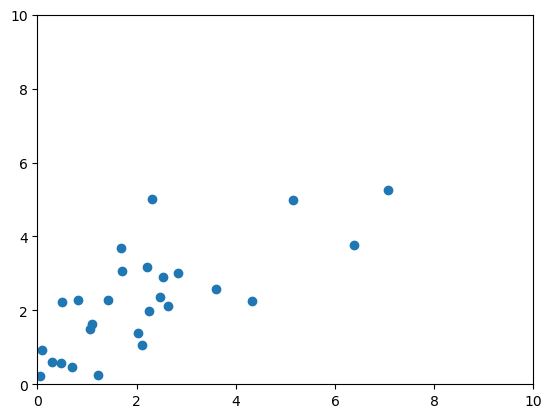

In [10]:
# We use a scatter plot to illustrate the predicted values against the actual values. We can visually check the prediction:
# if all the points are aligned on the 45-degree line, true values of y equals predicted values of y and the model
# perfectly predicted all the Win-Shares/Mins-Played

plt.scatter(y_test, predictions)
plt.xlim([0,10])
plt.ylim([0,10])

We see that the values don't fit on a 45-degree line. This means the model was inaccurate in predicting Win-Shares/Mins-Played.

In [8]:
# We use the test set to calculate evaluation metrics
mse, bias, var = bias_variance_decomp(model, X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(),
                                      loss='mse')

print("MAE:", metrics.mean_absolute_error(y_test, predictions))
print("MSE:", metrics.mean_squared_error(y_test, predictions))
print("\nR2 Score:", r2_score(y_test, predictions))
print("\nBias:", bias)
print("Variance:", var)

MAE: 0.9745849356937153
MSE: 1.6150715580300896

R2 Score: 0.5041172842197272

Bias: 1.6826790497075732
Variance: 0.69345057836667


R2 is negative, meaning none of the variance of y can be explained by our model prediction, and we are better off not using Linear Regression to make our predictions.